---
---
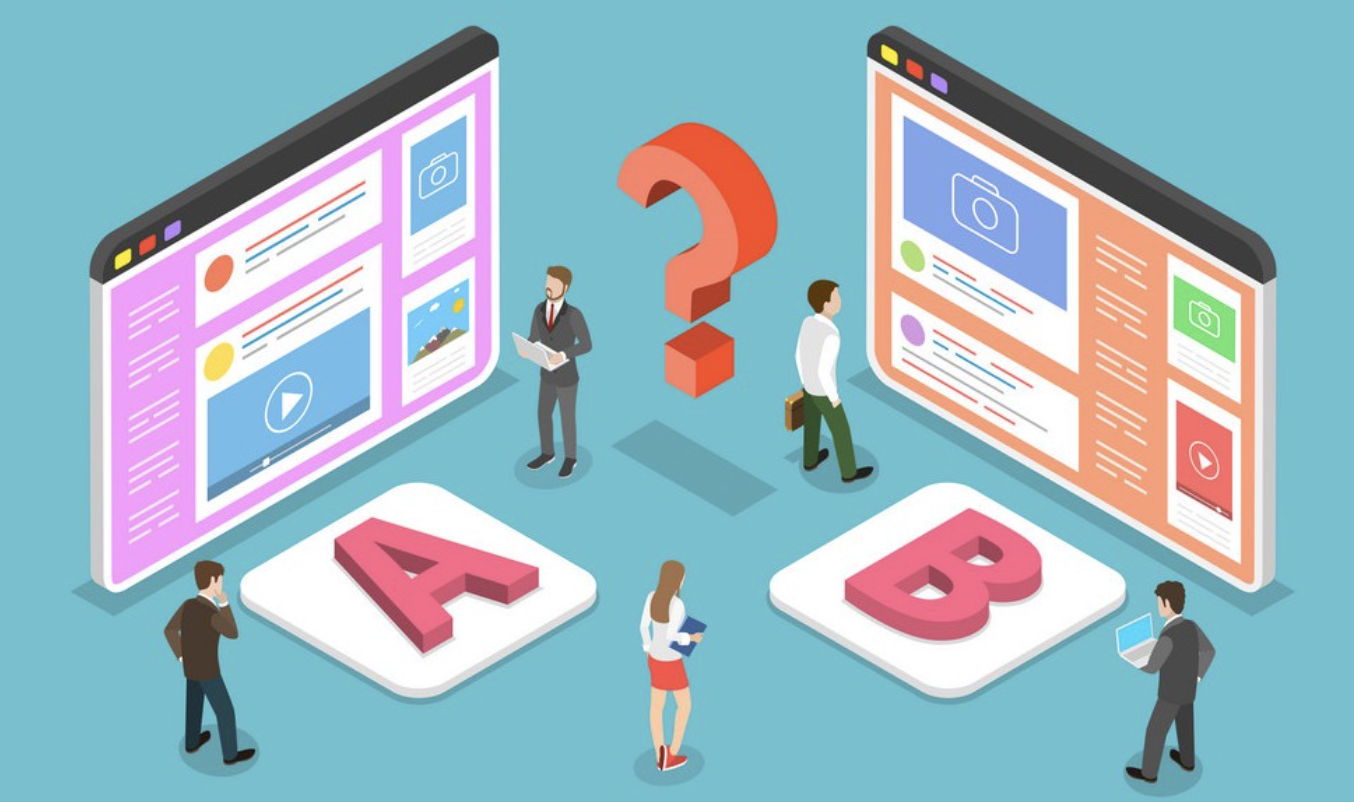



# Table of Contents
- [Introduction](#intro)
- [1 - Exploratory Data Analysis & Data Cleaning](#Eda&Cleaning)
- [2 - Probability](#probability)
- [3 - A/B Test](#ab_test)
- [4 - Regression](#regression)






<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that we get some practice working with the difficulties of these.

For this project, we will be working to understand the results of an A/B test run by an e-commerce website.  Our goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

Let's get to know the columns of the data:
- user_id - The user ID of each session
- timestamp - Timestamp for the session
- group - Which group the user was assigned to for that session {control, treatment}
- landing_page - Which design each user saw on that session {old_page, new_page}
- converted - Whether the session ended in a conversion or not (binary, 0=not converted, 1=converted)

 <a id='Eda&Cleaning'></a>
 
 ## 1 - Exploratory Data Analysis & Data Cleaning

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import skew
import warnings
warnings.filterwarnings('ignore')

# Libraries for Style
from colorama import Fore, Style
from yellowbrick.style import set_palette
set_palette('flatui')

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10,6)
# pd.set_option('display.max_columns', 100)
# pd.set_option('display.max_rows', 150)
pd.set_option('display.float_format', '{:.3f}'.format)

In [2]:
df = pd.read_csv('ab_test.csv')
df.head()

,id,time,con_treat,page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         294478 non-null  int64 
 1   time       294478 non-null  object
 2   con_treat  294478 non-null  object
 3   page       294478 non-null  object
 4   converted  294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [4]:
df.shape, df.size

((294478, 5), 1472390)

In [5]:
print('Missing Value   : ', df.isnull().sum().sum())
print('Duplicated Rows : ', df.duplicated().sum())

Missing Value   :  0
Duplicated Rows :  0


In [6]:
df.columns

Index(['id', 'time', 'con_treat', 'page', 'converted'], dtype='object')

In [7]:
# change column names 

df.columns = ["user_id", "timestamp", "group", "landing_page", "converted"]
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1


In [8]:
df.describe()   # Summary of numerical variables

,user_id,converted
count,294478.000,294478.000
mean,787974.125,0.120
std,91210.824,0.325
min,630000.000,0.000
25%,709032.250,0.000
50%,787933.500,0.000
75%,866911.750,0.000
max,945999.000,1.000


In [9]:
df.describe(include=['O']).T  # Summary of categorical variables

,count,unique,top,freq
timestamp,294478,35993,36:26.7,22
group,294478,2,treatment,147276
landing_page,294478,2,old_page,147239


In [10]:
df.converted.value_counts()

0    259241
1     35237
Name: converted, dtype: int64

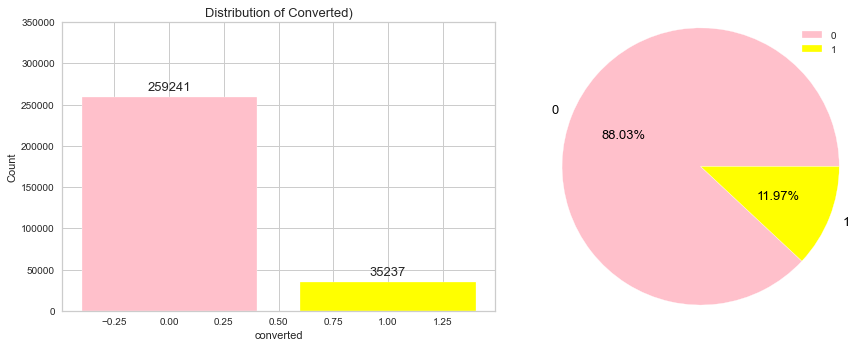

In [11]:
plt.figure(figsize=(13,5))

x = df['converted'].value_counts().index
y = df['converted'].value_counts().values

plt.subplot(121)
g = plt.bar(x, y, label='converted', color=['pink','yellow'])
plt.bar_label(g, padding=3, size=13), plt.ylim(0, 350000)

plt.xlabel('converted'), plt.ylabel('Count') 
plt.title('Distribution of Converted)', size=13)
   
plt.subplot(122)
plt.pie(y, labels=x, autopct='%0.2f%%', radius=1.2, textprops={'color':'black','fontsize': 13}, 
        colors=['pink','yellow'])
plt.legend()

plt.tight_layout();

In [12]:
# Number of rows and unique users:

print(f'Number of rows: {df.shape[0]}')
print(f'Number of unique users: {df.user_id.nunique()}')

Number of rows: 294478
Number of unique users: 290584


In [13]:
# Does the number of new_page and treatment match ?

n_treat = df[df["group"] == "treatment"].shape[0]
n_new_page = df[df["landing_page"] == "new_page"].shape[0]
difference = n_treat - n_new_page

pd.DataFrame({
    'N treatment': [n_treat],
    'N new_page': [n_new_page],
    'Difference': [difference]
})

,N treatment,N new_page,Difference
0,147276,147239,37


- There is mismatch between number of users assigned to treatment and the number of those landed on treatment page. This might indicate a problem with the data and needs further exploration.

In [14]:
# Lets see those rows 

df[(df["group"] == "treatment") & (df["landing_page"] == "old_page")]

,user_id,timestamp,group,landing_page,converted
308,857184,34:59.8,treatment,old_page,0
327,686623,26:40.7,treatment,old_page,0
357,856078,29:30.4,treatment,old_page,0
685,666385,11:54.8,treatment,old_page,0
713,748761,47:44.4,treatment,old_page,0
...,...,...,...,...,...
293773,688144,34:50.5,treatment,old_page,1
293817,876037,15:09.0,treatment,old_page,1
293917,738357,37:55.7,treatment,old_page,0
294014,813406,25:33.2,treatment,old_page,0


In [15]:
df_mismatch = df[(df["group"] == "treatment") & (df["landing_page"] == "old_page")
               |(df["group"] == "control") & (df["landing_page"] == "new_page")]

print(df_mismatch.shape)
n_mismatch = df_mismatch.shape[0]

percent_mismatch = round(n_mismatch / len(df) * 100, 2)
print(f'Number of mismatched rows: {n_mismatch} rows')
print(f'Percent of mismatched rows: {percent_mismatch} percent')

(3893, 5)
Number of mismatched rows: 3893 rows
Percent of mismatched rows: 1.32 percent


- As you can see, there are 3893 rows where treatment does not match with new_page or control does not match with old_page, we cannot be sure if this row truly received the new or old page. How we will deal with those rows?

In [16]:
df2 = df[(df["group"] == "treatment") & (df["landing_page"] == "new_page")
        |(df["group"] == "control") & (df["landing_page"] == "old_page")]

len(df2)

290585

In [17]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1


In [18]:
# Double Check all of the correct rows were removed 

df_mismatch = df2[(df2["group"] == "treatment") & (df2["landing_page"] == "old_page")
               |(df2["group"] == "control") & (df2["landing_page"] == "new_page")]

n_mismatch = df_mismatch.shape[0]

percent_mismatch = round(n_mismatch / len(df2) * 100, 2)
print(f'Number of mismatched rows: {n_mismatch} rows')
print(f'Percent of mismatched rows: {percent_mismatch} percent')

Number of mismatched rows: 0 rows
Percent of mismatched rows: 0.0 percent


In [19]:
# unique user id in df2 

df2.user_id.nunique()

290584

In [20]:
# Number of repeated ids in df2

len(df2) - df2.user_id.nunique()

1

In [21]:
# Display the duplicated row 

df2[df2.duplicated("user_id") == True]

,user_id,timestamp,group,landing_page,converted
2893,773192,55:59.6,treatment,new_page,0


In [22]:
# Drop the duplicated row

df2 = df2.drop_duplicates("user_id") 

In [23]:
# Douple Check that it is actually dropped

len(df2) - df2.user_id.nunique()

0

In [24]:
# Percent of convergance
# The probability of an individual converting regardless of the page they receive

df2.converted.mean() * 100

11.959708724499627

In [25]:
# Given that an individual was in the control group, what is the probability they converted?
# Given that an individual was in the treatment group, what is the probability they converted?

df2.user_id = df2.user_id.astype(str)
df2.groupby("group").mean() * 100

,converted
group,
control,12.039
treatment,11.881


In [26]:
#What is the probability that an individual received the new page?

pd.DataFrame(df2.landing_page.value_counts(normalize = True) * 100)

,landing_page
new_page,50.006
old_page,49.994


#### Is there a sufficient evidence to conclude that the new treatment page leads to more conversions?

1. The probability that an individual received the new page is 50%
2. The probability of an individual converting regardless of the page they receive is 11.96%
3. Given that an individual was in the control group, the probability they converted is 12.04%
4. Given that an individual was in the treatment group, the probability they converted is 11.88%

1 to 4 suggests that there is no significant difference in convergence between treatment and control groups. Therefore we may conclude that the new treatment page has no impact and does not lead to more conversions.

<a id='ab_test'></a>
## 3 - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time? How long do you run to render a decision that neither page is better than another?

These questions are the difficult parts associated with A/B tests in general. 

For now, consider you need to make the decision just based on all the data provided. If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%

**$H_{0}$**: **$p_{old}$** - **$p_{new}$** **$>= 0$**

**$H_{1}$**: **$p_{old}$** - **$p_{new}$** **$ < 0$**

In [27]:
# Creating the sampling distribution of difference in means 

means_diff = []
size = df.shape[0]
for _ in range(10000):
    sample = df2.sample(size, replace = True)
    control_mean = sample[sample["group"] == "control"]["converted"].mean()
    treat_mean = sample[sample["group"] == "treatment"]["converted"].mean()
    means_diff.append(treat_mean - control_mean)

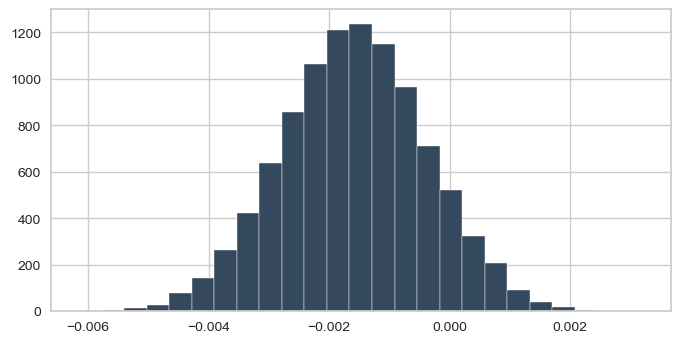

In [28]:
# Plotting the sampling distribution 

plt.figure(figsize = (8,4), dpi = 100)
plt.hist(means_diff, bins = 25)
plt.show()

In [29]:
# Simulate distribution under the null hypothesis

means_diff = np.array(means_diff)
null_vals = np.random.normal(0, means_diff.std(), means_diff.size)

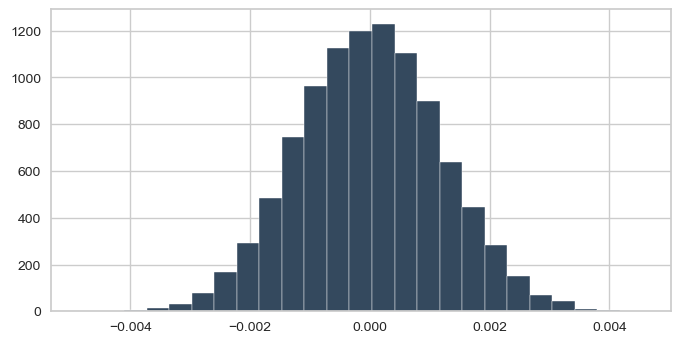

In [30]:
# Plot the null distribution

plt.figure(figsize = (8,4), dpi = 100)
plt.hist(null_vals, bins = 25)
plt.show()

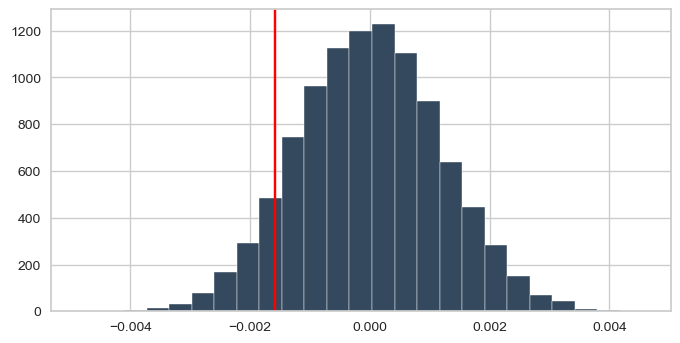

In [31]:
# Plot observed statistic with the null distibution

control_mean = df2[df2["group"] == "control"]["converted"].mean()
treat_mean = df2[df2["group"] == "treatment"]["converted"].mean()
obs_diff = treat_mean - control_mean

plt.figure(figsize = (8,4), dpi = 100)
plt.hist(null_vals, bins = 25)
plt.axvline(obs_diff, c='red')
plt.show()

In [32]:
# calculating the p value 

(null_vals > obs_diff).mean()

0.9077

#### Concluding remarks for this section so far:

1. The p_value (0.9) is greater than alpha, therefore we fail to reject the null.
2. This emphasizes of initial conclusion that there is no significant impact for the new page.

We could also use a built-in to achieve similar results. Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance.

In [33]:
import statsmodels.api as sm

convert_old = df2[(df2["converted"] == 1) & (df2["landing_page"] == "old_page")]['user_id'].nunique()
convert_new = df2[(df2["converted"] == 1) & (df2["landing_page"] == "new_page")]['user_id'].nunique()
n_old = df2[df["landing_page"] == "old_page"]['user_id'].nunique()
n_new = df2[df["landing_page"] == "new_page"]['user_id'].nunique()

In [34]:
#Compute test statistic and p-value

z_score, p_value = sm.stats.proportions_ztest(np.array([convert_new,convert_old]),np.array([n_new,n_old]), alternative = 'larger')

In [35]:
# Print Z Score and P_Value

z_score, p_value 

(-1.3109241984234394, 0.9050583127590245)

- Using test statistic and p-value, we reach the same coclusion: we can not reject the null 

<a id='regression'></a>
## 4 - Regression

In this final part, you will see that the result we achieved in the A/B test Part above can also be achieved by performing regression. Since each row is either a conversion or no conversion, we will use logestic regression to see if there is a significant difference in conversion based on which page a customer receives. However, we first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.

In [36]:
# Creat the intercept 

df2["intercept"] = 1
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept
0,851104,11:48.6,control,old_page,0,1
1,804228,01:45.2,control,old_page,0,1
2,661590,55:06.2,treatment,new_page,0,1
3,853541,28:03.1,treatment,new_page,0,1
4,864975,52:26.2,control,old_page,1,1


In [37]:
# Create ab_page column, which is 1 when an individual receives the treatment and 0 if control.

df2["ab_page"] = df2.group.apply(lambda x: 1 if (x == "treatment") else 0)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,11:48.6,control,old_page,0,1,0
1,804228,01:45.2,control,old_page,0,1,0
2,661590,55:06.2,treatment,new_page,0,1,1
3,853541,28:03.1,treatment,new_page,0,1,1
4,864975,52:26.2,control,old_page,1,1,0


In [38]:
# Instantiate and fit the regression model

model = sm.Logit(df2['converted'], df2[['intercept','ab_page']])
result = model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Wed, 04 May 2022   Pseudo R-squ.:               8.077e-06
Time:                        01:24:39   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

The P-Value is 0.190, It is different from the one we obtained from the previous analysis because the null hypothesis is different in both cases.

We might add additional features to our model such timestamp, the reason for that conversion might differ according to the time at which the user visits the website. But this might come with a disadvantage, the model will become more complicated and less interpretable. It might be also  susceptible to overfitting.


We will leave timestamp for now. Instead, along with testing if the conversion rate changes for different pages, we will also add an effect based on which country a user lives in. we will need to read in the countries.csv dataset and merge together your datasets on the appropriate rows.

In [41]:
# Read the country data

countries = pd.read_csv("countries_ab.csv")
countries.head()

,id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [43]:
# Merge the countries dataframe with df2.

countries.columns = ["user_id", "country"]
countries["user_id"] = countries["user_id"].astype(str)
df3 = df2.merge(countries, on = "user_id", how = "left")
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,11:48.6,control,old_page,0,1,0,US
1,804228,01:45.2,control,old_page,0,1,0,US
2,661590,55:06.2,treatment,new_page,0,1,1,US
3,853541,28:03.1,treatment,new_page,0,1,1,US
4,864975,52:26.2,control,old_page,1,1,0,US


In [44]:
# creating dummies for country and landing_page columns  

df3[['CA','UK','US']] = pd.get_dummies(df3['country'])
df3[['new_page','old_page']] = pd.get_dummies(df3['landing_page'])
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US,new_page,old_page
0,851104,11:48.6,control,old_page,0,1,0,US,0,0,1,0,1
1,804228,01:45.2,control,old_page,0,1,0,US,0,0,1,0,1
2,661590,55:06.2,treatment,new_page,0,1,1,US,0,0,1,1,0
3,853541,28:03.1,treatment,new_page,0,1,1,US,0,0,1,1,0
4,864975,52:26.2,control,old_page,1,1,0,US,0,0,1,0,1


In [45]:
# lest see if there is a relation between country and conversion

pd.pivot_table(data = df3, index = "country", values = "converted").sort_values(by = "converted", ascending = False) * 100

,converted
country,
UK,12.059
US,11.955
CA,11.532


It seems that coutry has a very minor impact on convergance. we will see its true impact along with ather features in the regression# Instantiate and fit the regression model
model = sm.Logit(df2['converted'], df2[['intercept','ab_page']])
result = model.fit()
result.summary()# Instantiate and fit the regression model
model = sm.Logit(df2['converted'], df2[['intercept','ab_page']])
result = model.fit()
result.summary()

In [46]:
# Instantiate and fit the regression model with country as an additional variable: 'CA' is a baseline

model = sm.Logit(df3['converted'], df3[['intercept','ab_page', 'UK','US']])
result = model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Wed, 04 May 2022   Pseudo R-squ.:               2.323e-05
Time:                        01:29:56   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
US             0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

In [ ]:
# exponentiate the parameters to inteprete the result

np.exp(result.params)

intercept   0.131
ab_page     0.985
UK          1.052
US          1.042
dtype: float64

- All the coefficients are statistically insignificant except the intercept. This comes inline with the initial conclusions that we have just made.

### Summary:
In this notebook we conducted a detailed A/B testing using 3 main methods:
1. Sampling distribution
2. Z test
3. Logestic regression 

All three methods resulted in the same conclusion: the treatment has no impact.

### Conclusions:
None of the variables have significant p-values. Therefore, we will fail to reject the null and conclude that there is not sufficient evidence to suggest that there is an interaction between country and page received that will predict whether a user converts or not.

In the larger picture, based on the available information, we do not have sufficient evidence to suggest that the new page results in more conversions than the old page.

---
---